In [9]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

#Get the ISO-Codes
iso = pd.read_csv("../../Data/ISO/ISO.csv")

In [10]:
# --- : Load DataFrames from CSV ---
print("\nLoading W_ij Dataframes from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['../../Data/Networks/W_1_ij.csv', '../../Data/Networks/W_2_ij.csv', '../../Data/Networks/W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        base_name = os.path.basename(filename) # Gets 'W_1_ij.csv'
        parts = base_name.split('_') # Splits into ['W', '1', 'ij.csv']
        
        # Check if the parts list has at least 2 elements and the second part is a number
        if len(parts) >= 2 and parts[1].isdigit():
            df_number = parts[1]
            new_df_name = f"W_{df_number}_ij"
        else:
            # Fallback if filename format is unexpected, or use the full name as before
            new_df_name = os.path.splitext(base_name)[0] 
            
        W_ij_dataframes[new_df_name] = df_reloaded
        print(f"Loaded {filename} as {new_df_name}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij Dataframes from CSV files...
Loaded ../../Data/Networks/W_1_ij.csv as W_1_ij
Loaded ../../Data/Networks/W_2_ij.csv as W_2_ij
Loaded ../../Data/Networks/W_3_ij.csv as W_3_ij


In [11]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 81353, Filtered rows: 69127
Filtered W_2_ij. Original rows: 34585, Filtered rows: 29382
Filtered W_3_ij. Original rows: 94775, Filtered rows: 78649



Saving plot to ../../../Writing/Master/figures/network_density_plot.png with 300 DPI...
Plot saved successfully!


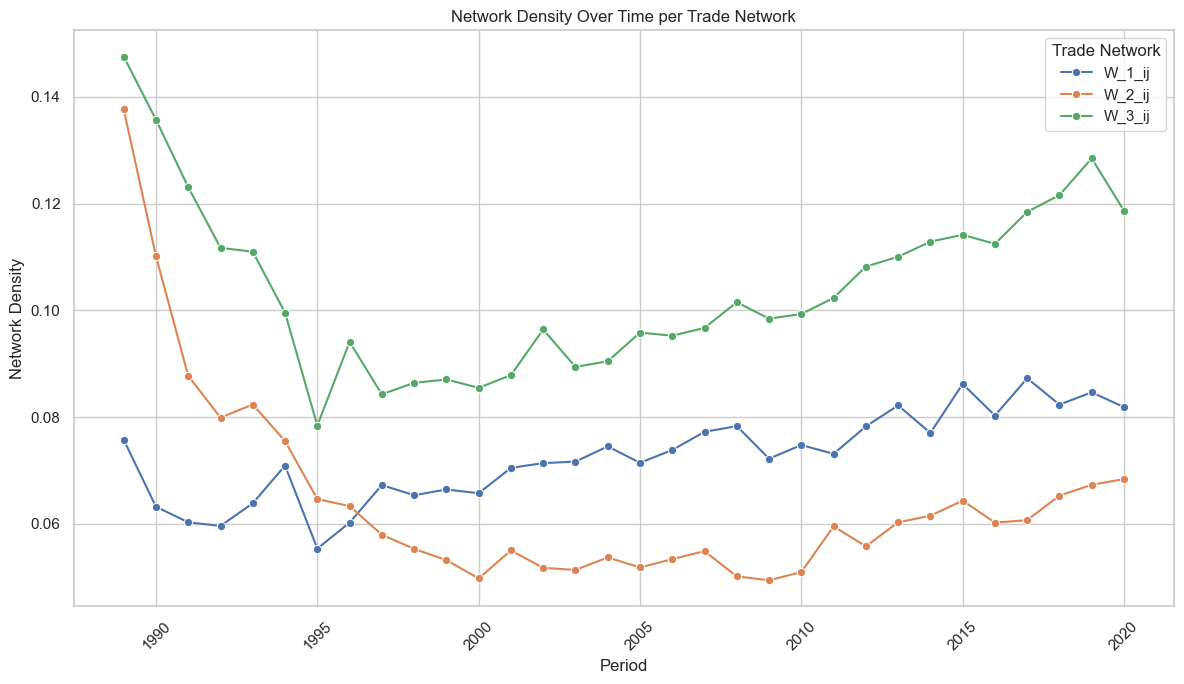

In [12]:
def calculate_network_density(df):
    yearly_density = []
    
    for year, group in df.groupby('period'):
        G = nx.DiGraph()
        for _, row in group.iterrows():
            G.add_edge(row['reporterISO'], row['partnerISO'])
        
        density = nx.density(G)
        yearly_density.append({'period': year, 'network_density': density})
    
    return pd.DataFrame(yearly_density)

df_density_W1 = calculate_network_density(W_ij_dataframes["W_1_ij"])
df_density_W1 = df_density_W1.rename(columns={'network_density': 'W_1_ij'})

df_density_W2 = calculate_network_density(W_ij_dataframes["W_2_ij"])
df_density_W2 = df_density_W2.rename(columns={'network_density': 'W_2_ij'})

df_density_W3 = calculate_network_density(W_ij_dataframes["W_3_ij"])
df_density_W3 = df_density_W3.rename(columns={'network_density': 'W_3_ij'})

merged_df = pd.merge(df_density_W1, df_density_W2, on='period', how='outer').fillna(0)
merged_df = pd.merge(merged_df, df_density_W3, on='period', how='outer').fillna(0)

# Reshape the dataframe from wide to long format for Seaborn
long_format_df = pd.melt(merged_df, id_vars=['period'], var_name='DataFrame', value_name='network_density')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=long_format_df,
    x='period',
    y='network_density',
    hue='DataFrame',
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('Network Density')
plt.title('Network Density Over Time per Trade Network')
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

output_filename = '../../../Writing/Master/figures/network_density_plot.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except Exception as e:
    print(f"Error saving plot: {e}")

C:\Users\nilsl\AppData\Local\Temp\ipykernel_35048\2821213142.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Trade Network')



Saving plot to degree_distribution_histogram.png with 300 DPI...
Plot saved successfully!


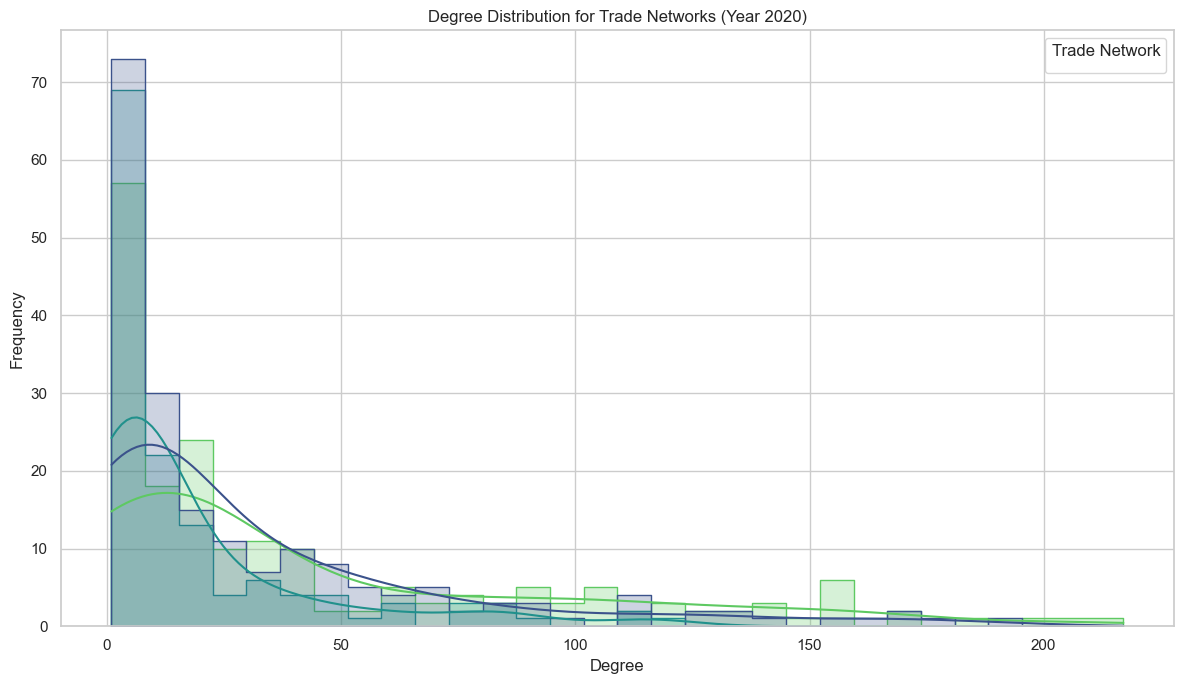

In [13]:
def calculate_degree_distribution_for_year(df, year):
    """Calculates the degree distribution for a given year."""
    yearly_df = df[df['period'] == year]
    
    if yearly_df.empty:
        print(f"No data available for year {year}. Returning empty list.")
        return []
    
    G = nx.DiGraph()
    for _, row in yearly_df.iterrows():
        G.add_edge(row['reporterISO'], row['partnerISO'])
    
    # Calculate degree for each node (in-degree + out-degree)
    degrees = [val for (node, val) in G.degree()]
    return degrees

# Get the last year from the dataframes. Assuming they all have the same periods.
last_year = W_ij_dataframes["W_1_ij"]['period'].max()

# Calculate the degree distribution for each network for the last year
degrees_W1 = calculate_degree_distribution_for_year(W_ij_dataframes["W_1_ij"], last_year)
degrees_W2 = calculate_degree_distribution_for_year(W_ij_dataframes["W_2_ij"], last_year)
degrees_W3 = calculate_degree_distribution_for_year(W_ij_dataframes["W_3_ij"], last_year)

# Create a DataFrame for plotting
df_W1 = pd.DataFrame({'Trade Network': 'W_1_ij', 'Degree': degrees_W1})
df_W2 = pd.DataFrame({'Trade Network': 'W_2_ij', 'Degree': degrees_W2})
df_W3 = pd.DataFrame({'Trade Network': 'W_3_ij', 'Degree': degrees_W3})

combined_df = pd.concat([df_W1, df_W2, df_W3])

# Create the histogram
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(
    data=combined_df,
    x='Degree',
    hue='Trade Network',
    element='step',
    bins=30, # Adjust bin count as needed
    kde=True,
    palette='viridis'
)

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title(f'Degree Distribution for Trade Networks (Year {last_year})')
plt.legend(title='Trade Network')
plt.tight_layout()

output_filename = 'degree_distribution_histogram.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except Exception as e:
    print(f"Error saving plot: {e}")